# Loan Performance Prediction
This notebook shows my work of building a regression model to predict the number of months until the mortgage is taken off the books due to foreclosure, prepayment, etc.. (NMONTHS)

## 1. Load Dataset

In [142]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [157]:
## TRAIN
df = pd.read_csv("TRAIN.csv") # # (164575, 34)

## TEST
dfTEST = pd.read_csv("TEST.csv")

## VariablesUsed
var = pd.read_csv("VariablesUsed.csv") 
varU = var.loc[var.used] # (32, 4)

## 2. Replace Nan Values

In [159]:
## Replace Nan with column means
num_Col = varU.loc[varU.dtype=='np.float64'].abbreviated_name
dfR = df.fillna(df[list(num_Col)].mean())
dfTEST = dfTEST.fillna(dfTEST[list(num_Col)].mean())

## 3. Feature Extraction

In [160]:
## Drop repeated features
corrF =  df.iloc[:,:-2].corr().abs()
upper = corrF.where(np.triu(np.ones(corrF.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('drop feature:',to_drop)
## Update Data for Regression
dfR = df
dfR.drop(to_drop, axis=1, inplace=True)
dfTEST.drop(to_drop, axis=1, inplace=True)

drop feature: ['CRATE', 'TMTLM', 'RMTM']


In [161]:
## Drop Low Correlated features with Response Variables
corrR =  dfR.iloc[:,:-2].corrwith(dfR.iloc[:,-1]).abs()
to_drop2 = ['LID','CLDS']
print('drop feature:',to_drop2)
## Update Data for Regression
dfR.drop(to_drop2, axis=1, inplace=True)
dfTEST.drop(to_drop2, axis=1, inplace=True)

drop feature: ['LID', 'CLDS']


## 4. Visualize and Convert Features

In [162]:
dfR["MRP"] = pd.to_datetime(dfR["MRP"]).dt.month
dfTEST["MRP"] = pd.to_datetime(dfTEST["MRP"]).dt.month
# sns.regplot(x='MRP', y='NMONTHS',data=dfR,fit_reg=False,x_bins=3)

In [163]:
## Category Features
# sns.regplot(x='CHANNEL', y='NMONTHS',data=dfC, fit_reg=False,x_bins=3)
cat_F = ['CHANNEL','SELLER','FTHBI','LP','PTYPE','NUNITS','OCCSTAT','STATE','RMI']
dfR[cat_F]=dfR[cat_F].astype('category')
dfTEST[cat_F]=dfTEST[cat_F].astype('category')
# replace with numeric values
cat_columns = dfR.select_dtypes(['category']).columns
dfR[cat_columns] = dfR[cat_columns].apply(lambda x: x.cat.codes)
dfTEST[cat_columns] = dfTEST[cat_columns].apply(lambda x: x.cat.codes)

In [164]:
dfR["CHANNEL"] = dfR.CHANNEL.replace(0,1.75)
# sns.regplot(x='CHANNEL', y='NMONTHS',data=dfR,fit_reg=False,x_bins=4)
# sns.regplot(x='ORATE', y='NMONTHS',data=dfR, fit_reg=False,x_bins=50)
dfR["OUPB"]=np.log(dfR.OUPB)
# sns.regplot(x='OUPB', y='NMONTHS',data=dfR, fit_reg=False,x_bins=50)
ODATE_dM = pd.to_datetime(dfR["ODATE"])-min(pd.to_datetime(dfR["ODATE"]))
dfR["ODATE"] = ODATE_dM / np.timedelta64(1, 'M')
# sns.regplot(x="ODATE", y='NMONTHS',data=dfR,fit_reg=False,x_bins=1000)
# sns.regplot(x='OLTERM', y='NMONTHS',data=dfR,fit_reg=False,x_bins=200)
# sns.regplot(x="LA", y='NMONTHS',data=dfC,fit_reg=False,x_bins=100)

In [165]:
# dfR.FPD.value_counts()
FPD_dM = pd.to_datetime(dfR["FPD"])-min(pd.to_datetime(dfR["FPD"]))
# dfR["FPD"] = FPD_dM / np.timedelta64(1, 'M')
# sns.regplot(x="FPD", y='NMONTHS',data=dfR,fit_reg=False,x_bins=100)
# dfR.FPD.corr(dfC.ODATE)
# dfR.drop('FPD', axis=1, inplace=True)

In [166]:
dfTEST["CHANNEL"] = dfTEST.CHANNEL.replace(0,1.75)
dfTEST["OUPB"]=np.log(dfTEST.OUPB)
ODATE_dMTEST = pd.to_datetime(dfTEST["ODATE"])-min(pd.to_datetime(dfTEST["ODATE"]))
dfTEST["ODATE"] = ODATE_dMTEST / np.timedelta64(1, 'M')

In [167]:
dfR["DTI"] = dfR.DTI.fillna(dfR.DTI.mean())
# sns.regplot(x='DTI', y="NMONTHS",data=dfR,fit_reg=False,x_bins=50)
dfTEST["DTI"] = dfTEST.DTI.fillna(dfTEST.DTI.mean())

In [168]:
# set(dfR.DTI.isna())
# sns.regplot(x="LOTV", y="NMONTHS",data=dfR,fit_reg=False,x_bins=50)
dfR["LOTV"] = dfR.LOTV.fillna(dfR.LOTV.mean())
dfTEST["LOTV"] = dfTEST.LOTV.fillna(dfTEST.LOTV.mean())

### Non-Trending or Repeatative Features

In [170]:
MDATE = dfR.MDATE.astype('string')
for i,mdate in enumerate(MDATE):
    if len(mdate)<6:
        MDATE[i] = '0'+mdate
    else:
        MDATE[i] = mdate
MDATE = pd.to_datetime(MDATE,format="%m%Y")
MDATE = (MDATE-min(MDATE))/np.timedelta64(1, 'Y')
# MDATE=np.exp(dfC.MDATE)
# sns.regplot(x="MDATE", y='NMONTHS',data=dfC,fit_reg=False)
# dfC.MDATE.value_counts()

<AxesSubplot:xlabel='CLTV', ylabel='NMONTHS'>

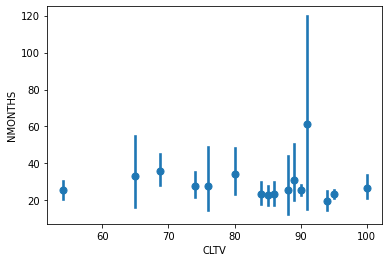

In [171]:
sns.regplot(x="CLTV", y="NMONTHS",data=dfR.loc[dfR.CLTV>0],fit_reg=False,x_bins=50)

<AxesSubplot:xlabel='CBCSAO', ylabel='NMONTHS'>

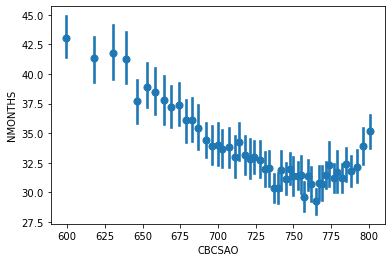

In [172]:
sns.regplot(x="CBCSAO", y="NMONTHS",data=dfR.loc[dfR.CBCSAO>0],fit_reg=False,x_bins=50)
# highly correlated with BCSAO

In [173]:
MIT = dfR.MIT.fillna(dfR.MIT.mean())
# sns.regplot(x="MIT", y="NMONTHS",data=dfR.loc[dfR.MIT.dropna()],fit_reg=False)

<AxesSubplot:xlabel='NB', ylabel='NMONTHS'>

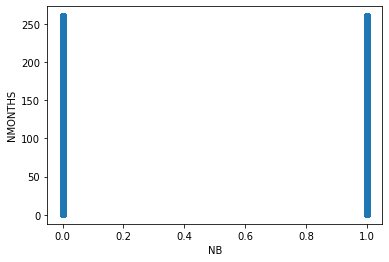

In [175]:
# sns.regplot(x='NB', y="NMONTHS",data=dfR,fit_reg=False,x_bins=500)
NB1 = pd.Series(dfR.NB==2,dtype='int')
NB4 = pd.Series(dfR.NB==4,dtype='int')
sns.regplot(x=NB1, y="NMONTHS",data=dfR,fit_reg=False)
# sns.regplot(x=NB4, y="NMONTHS",data=dfR,fit_reg=False)

In [176]:
## Useless/Repeated Features
to_drop3 = ['FPD','MDATE','CLTV','CBCSAO','MIT','NB','BCSAO','MSA','ZIP','MIP',]
dfR.drop(to_drop3, axis=1, inplace=True)
dfTEST.drop(to_drop3, axis=1, inplace=True)

In [177]:
dfTEST.head()

,MRP,CHANNEL,SELLER,ORATE,OUPB,OLTERM,ODATE,LA,LOTV,DTI,FTHBI,LP,PTYPE,NUNITS,OCCSTAT,STATE,RMI
0,3,2.00,7,8.625,11.617285,360,13.010534,0,71.0,36.0,0,1,4,0,1,22,0
1,1,1.00,3,8.250,11.561716,360,9.987885,1,90.0,55.0,0,1,2,0,1,29,0
2,1,2.00,14,7.375,11.775290,180,9.987885,1,61.0,19.0,0,1,4,0,1,16,0
3,3,1.75,10,8.500,10.968198,180,11.992033,1,70.0,38.0,0,0,4,0,0,44,0
4,2,1.00,12,7.875,12.043554,360,11.992033,0,80.0,25.0,1,1,4,0,1,14,0


In [180]:
dfR.columns

Index(['MRP', 'CHANNEL', 'SELLER', 'ORATE', 'OUPB', 'OLTERM', 'ODATE', 'LA',
       'LOTV', 'DTI', 'FTHBI', 'LP', 'PTYPE', 'NUNITS', 'OCCSTAT', 'STATE',
       'RMI', 'FORECLOSED', 'NMONTHS'],
      dtype='object')

In [181]:
dfR.to_csv('dfR.csv')
dfTEST.to_csv('dfTEST.csv') 

### 5. Train Model

In [182]:
# train-test 70-30 split
df_train, df_test = train_test_split(dfR, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)
y1_train = df_train.pop('NMONTHS')
y2_train = df_train.pop('FORECLOSED')
y2_train = y2_train.astype('float64')
X_train = df_train

y1_test = df_test.pop('NMONTHS')
y2_test = df_test.pop('FORECLOSED')
X_test = df_test

In [183]:
lm = LinearRegression()
lm.fit(X_train, y1_train)

rfe = RFE(lm, n_features_to_select=15)             
rfe = rfe.fit(X_train, y1_train)

In [184]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MRP', True, 1),
 ('CHANNEL', True, 1),
 ('SELLER', True, 1),
 ('ORATE', True, 1),
 ('OUPB', True, 1),
 ('OLTERM', False, 3),
 ('ODATE', True, 1),
 ('LA', True, 1),
 ('LOTV', True, 1),
 ('DTI', False, 2),
 ('FTHBI', True, 1),
 ('LP', True, 1),
 ('PTYPE', True, 1),
 ('NUNITS', True, 1),
 ('OCCSTAT', True, 1),
 ('STATE', True, 1),
 ('RMI', True, 1)]

*tuples of (feature name, whether selected, ranking (> 1 for non-selected features))*

In [185]:
# lm simply-split prediction
y1_pred = rfe.predict(X_test)
rfe.score(X_test, y1_test)

0.10241351752629502

In [186]:
# lm cross-validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(rfe, X_train, y1_train, scoring='r2', cv=5)
print('lm R^2',scores.mean())

lm R^2 0.10141941154064746


## 6. Save Prediction on TEST.csv

In [187]:
NMONTHS_pred = rfe.predict(dfTEST)

In [188]:
TEST = pd.read_csv("TEST.csv")

In [190]:
PREDS = pd.DataFrame({'LID':TEST.LID.astype('str'),
                     'NMONTHS':NMONTHS_pred})
PREDS.to_csv('PREDS.csv',index=False)